<a href="https://colab.research.google.com/github/hhoppe/advent_of_code_2017/blob/main/advent_of_code_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advent of code 2017

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code_2017/blob/main/advent_of_code_2017.ipynb)

IPython/Jupyter [notebook](https://github.com/hhoppe/advent_of_code_2017/blob/main/advent_of_code_2017.ipynb) by [Hugues Hoppe](http://hhoppe.com/) with solutions to the [2017 Advent of Code puzzles](https://adventofcode.com/2017).
Completed in November 2022.

In this notebook, I explore both "compact" and "fast" code versions, along with data visualizations.

I was able to speed up all the solutions such that the [cumulative time](#timings) across all 25 puzzles is about 2 s.
(For some puzzles, I had to resort to the `numba` package to jit-compile Python functions.)

Here are some visualization results:

<a href="#day14">day14</a><img src="https://github.com/hhoppe/advent_of_code_2017/raw/main/results/day14.png" width="256"> &emsp;
<a href="#day22">day22</a><img src="https://github.com/hhoppe/advent_of_code_2017/raw/main/results/day22.png" width="335">
<br/>
<a href="#day21">day21</a><img src="https://github.com/hhoppe/advent_of_code_2017/raw/main/results/day21.png" width="867">

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null

In [2]:
!pip install -q advent-of-code-hhoppe hhoppe-tools mediapy numba

In [3]:
from __future__ import annotations

import collections
from collections.abc import Iterator
import dataclasses
import functools
import itertools
import operator
import re
import textwrap
from typing import Any

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import mediapy as media
import numpy as np

In [4]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [5]:
hh.start_timing_notebook_cells()

In [6]:
YEAR = 2017

In [7]:
# (1) To obtain puzzle inputs and answers, we first try these paths/URLs:
PROFILE = 'github.hhoppe.1452460'
# PROFILE = 'google.Hugues_Hoppe.965276'
TAR_URL = f'https://github.com/hhoppe/advent_of_code_{YEAR}/raw/main/data/{PROFILE}.tar.gz'
if 1:
  hh.run(f"if [ ! -d data/{PROFILE} ]; then (mkdir -p data && cd data &&"
         f" wget -q {TAR_URL} && tar xzf {PROFILE}.tar.gz); fi")
INPUT_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}_input.txt'
ANSWER_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'

In [8]:
# (2) If URL not found, we may try adventofcode.com using a session cookie:
if 0:
  # See https://github.com/wimglenn/advent-of-code-data.
  hh.run('rm -f ~/.config/aocd/token*')
  # Fill-in the session cookie in the following:
  hh.run(f"if [ '{PROFILE}' = 'github.hhoppe.1452460' ]; then mkdir -p ~/.config/aocd; echo 53616... >~/.config/aocd/token; fi")
  hh.run(f"if [ '{PROFILE}' = 'google.Hugues_Hoppe.965276' ]; then mkdir -p ~/.config/aocd && echo 53616... >~/.config/aocd/token; fi")
  hh.run('pip install -q advent-of-code-data')
  import aocd

In [9]:
try:
  import numba
  numba_njit = numba.njit
except ModuleNotFoundError:
  print('Package numba is unavailable.')
  numba_njit = hh.noop_decorator

In [10]:
advent = advent_of_code_hhoppe.Advent(
    year=YEAR, input_url=INPUT_URL, answer_url=ANSWER_URL)

In [11]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [12]:
check_eq = hh.check_eq
_ORIGINAL_GLOBALS = list(globals())

<a name="day1"></a>
## Day 1: Digits in a circular list

- Part 1: Find the sum of all digits that match the next digit in the list.

- Part 2: Instead of considering the next digit, consider the digit halfway around the circular list.

In [13]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2017/day/1), `puzzle.input` has a single line of 2_184 characters:

87893823215734275675425471658697512539486529734932123658657466299442989425982853 ... 62844329188218189254491238956497568


The stored answers are: `{1: '1175', 2: '1166'}`

In [14]:
def process1(s, part2=False):
  digits = [int(ch) for ch in s.strip('\n')]
  total = 0
  offset = len(digits) // 2 if part2 else 1
  for d0, d1 in zip(digits, digits[offset:] + digits[:offset]):
    if d0 == d1:
      total += d0
  return total

check_eq(process1('1122'), 3)
check_eq(process1('1111'), 4)
check_eq(process1('1234'), 0)
check_eq(process1('91212129'), 9)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2('1212'), 6)
check_eq(process2('1221'), 0)
check_eq(process2('123425'), 4)
check_eq(process2('123123'), 12)
check_eq(process2('12131415'), 4)
puzzle.verify(2, process2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day2"></a>
## Day 2: Rows of numbers

- Part 1: Find sum of differences between largest and smallest value in each row.

- Part 2: Find in each row the only 2 numbers where one evenly divides the other.  Sum the divisions.

In [15]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2017/day/2), `puzzle.input` has 16 lines:

1224	926	1380	688	845	109	118	88	1275	1306	91	796	102	1361	27	995
1928	2097	138	1824	198	117	1532	2000	1478	539	1982	125	1856	139	475	1338
848	202	1116	791	1114	236	183	186	150	1016	1258	84	952	1202	988	866
946	155	210	980	896	875	925	613	209	746	147	170	577	942	475	850
1500	322	43	95	74	210	1817	1631	1762	128	181	716	171	1740	145	1123
3074	827	117	2509	161	206	2739	253	2884	248	3307	2760	2239	1676	1137	3055
183	85	143	197	243	72	291	279	99	189	30	101	211	209	77	198
175	149	259	372	140	250	168	142	146	284	273	74	162	112	78	29
 ...
3421	1404	2360	2643	3186	3352	1112	171	168	177	146	1945	319	185	2927	2289
543	462	111	459	107	353	2006	116	2528	56	2436	1539	1770	125	2697	2432
1356	208	5013	4231	193	169	3152	2543	4430	4070	4031	145	4433	4187	4394	1754
5278	113	4427	569	5167	175	192	3903	155	1051	4121	5140	2328	203	5653	3233


The stored answers are: `{1: '34581', 2: '214'}`

In [16]:
s1 = """
5 1 9 5
7 5 3
2 4 6 8
"""

In [17]:
s2 = """
5 9 2 8
9 4 7 3
3 8 6 5
"""

In [18]:
def process1(s, part2=False):
  total = 0

  for line in s.strip('\n').split('\n'):
    values = [int(field) for field in line.split()]
    if not part2:
      difference = max(values) - min(values)
      total += difference
    else:
      for value1, value2 in itertools.permutations(values, 2):
        if value1 % value2 == 0:
          total += value1 // value2
          break

  return total


check_eq(process1(s1), 18)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s2), 9)
puzzle.verify(2, process2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day3"></a>
## Day 3: Spiral memory

- Part 1: Find the Manhattan distance (from the origin) of the nth spiral entry.

- Part 2: Successively, each spiral value is the sum of its 3x3 neighborhood; find the first value that is larger than the puzzle input.

In [19]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2017/day/3), `puzzle.input` has a single line of 6 characters:

277678


The stored answers are: `{1: '475', 2: '279138'}`

In [20]:
def spiral_yx():
  """Yields y, x coordinates of successive spiral entries."""
  yield 0, 0  # Value 1.
  yield 0, 1  # Value 2.
  yield -1, 1  # Value 3.
  y, x = -1, 1
  arm = 2
  while True:
    for _ in range(arm):
      x -= 1
      yield y, x
    for _ in range(arm):
      y += 1
      yield y, x
    arm += 1
    for _ in range(arm):
      x += 1
      yield y, x
    for _ in range(arm):
      y -= 1
      yield y, x
    arm += 1

In [21]:
def process1(s):  # Slow version.
  value = int(s)
  y, x = next(itertools.islice(spiral_yx(), value - 1, None))
  return abs(y) + abs(x)

check_eq(process1('1'), 0)
check_eq(process1('12'), 3)
check_eq(process1('22'), 3)
check_eq(process1('23'), 2)
check_eq(process1('24'), 3)
check_eq(process1('1024'), 31)
puzzle.verify(1, process1)

(Part 1: 0.011 s)


In [22]:
def process1(s):  # Fast version.
  value = int(s)
  result = {1: 0, 2: 1, 3: 2}.get(value)
  if result is not None:
    return result
  n = 4
  arm = 2
  count = 0  # 0 or 1
  while n + arm <= value:
    n += arm
    count += 1
    if count == 2:
      count = 0
      arm += 1
  xd = value - n - (arm // 2 - 1)
  r = (arm + count) // 2
  d = abs(xd) + r
  return d

check_eq(process1('1'), 0)
check_eq(process1('12'), 3)
check_eq(process1('22'), 3)
check_eq(process1('23'), 2)
check_eq(process1('24'), 3)
check_eq(process1('1024'), 31)
puzzle.verify(1, process1)

(Part 1: 0.000 s)


In [23]:
def process2(s, size=41):
  value = int(s)
  grid = np.zeros((size, size), dtype=np.int32)
  g = size // 2  # The first value 1 is located at central grid[g, g].
  for y0, x0 in spiral_yx():
    y, x = y0 + g, x0 + g
    assert y >= 1 and x >= 1
    count = max(np.sum(grid[y - 1: y + 2, x - 1: x + 2]), 1)
    grid[y, x] = count
    if count > value:
      return count

check_eq(process2('1'), 2)
check_eq(process2('2'), 4)
check_eq(process2('4'), 5)
check_eq(process2('5'), 10)
check_eq(process2('59'), 122)
puzzle.verify(2, process2)

(Part 2: 0.000 s)


<a name="day4"></a>
## Day 4: Valid passphrases

- Part 1: How many passphrases contain no duplicate words?

- Part 2: What if in addition, no two words may be anagrams of each other?

In [24]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2017/day/4), `puzzle.input` has 512 lines:

pphsv ojtou brvhsj cer ntfhlra udeh ccgtyzc zoyzmh jum lugbnk
vxjnf fzqitnj uyfck blnl impo kxoow nngd worcm bdesehw
caibh nfuk kfnu llfdbz uxjty yxjut jcea
qiho qif eupwww avyglnj nxzotsu hio lws
xjty usocjsh pivk qnknunc yjcgh bwya djw zpyr
ycfmfe mgq sjiomg nfzjul bjwkmgu yvsnvgj dcjupu wzz blmn
rdowgbt vpwfdoi blzl laghnk gsa vhnpo cztxzlb rtz hvwonhb eciju pfjtbo
bqs bqs dbutvgf mmzb izpyud rap izpyud xlzeb mnj hjncs
 ...
lfd eops govslp ultbye vrqai hcjkcf snpape
cbok koumkad otpozb pqcs emilpe wpcyvxd bock
spjb xkkak anuvk ejoklh nyerw bsjp zxuq vcwitnd xxtjmjg zfgq xkpf
juo pmiyoh xxk myphio ogfyf dovlmwm moevao qqxidn


The stored answers are: `{1: '466', 2: '251'}`

In [25]:
s1 = """
aa bb cc dd ee
aa bb cc dd aa
aa bb cc dd aaa
"""

In [26]:
s2 = """
abcde fghij
abcde xyz ecdab
a ab abc abd abf abj
iiii oiii ooii oooi oooo
oiii ioii iioi iiio
"""

In [27]:
def process1(s, part2=False):
  num_valid = 0

  for line in s.strip('\n').split('\n'):
    words = line.split()
    valid = len(words) == len(set(words))
    if valid and part2:
      words_with_sorted_letters = [''.join(sorted(word)) for word in words]
      valid = len(words_with_sorted_letters) == len(set(words_with_sorted_letters))
    num_valid += valid

  return num_valid


check_eq(process1(s1), 2)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s2), 3)
puzzle.verify(2, process2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day5"></a>
## Day 5: Update and follow jumps

- Part 1: After each jump, the offset of that instruction increases by 1.  How many steps does it take to reach the exit?

- Part 2: Same, but after each jump, if the offset was three or more, instead decrease it by 1.

In [28]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2017/day/5), `puzzle.input` has 1_003 lines:

1
2
0
0
0
2
-2
-2
 ...
-215
-896
-216
-477


The stored answers are: `{1: '326618', 2: '21841249'}`

In [29]:
s1 = """
0
3
0
1
-3
"""

In [30]:
def process1(s, part2=False):  # Slow.
  values = [int(s2) for s2 in s.strip('\n').split('\n')]
  pos = 0

  for num_steps in itertools.count(1):
    offset = values[pos]
    values[pos] = offset - 1 if (part2 and offset >= 3) else offset + 1
    pos += offset
    if not 0 <= pos < len(values):
      return num_steps


check_eq(process1(s1), 5)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 10)
if 0:
  puzzle.verify(2, process2)  # ~2.2 s.

(Part 1: 0.032 s)


In [31]:
def process1(s, part2=False):  # Fast.
  values = np.array([int(s2) for s2 in s.strip('\n').split('\n')], dtype=np.int64)

  @numba_njit(cache=True)
  def compute(values: Any) -> int:
    pos = 0
    num_steps = 0
    while 0 <= pos < len(values):
      num_steps += 1
      offset = values[pos]
      values[pos] = offset - 1 if (part2 and offset >= 3) else offset + 1
      pos += offset
    return num_steps

  return compute(values)


check_eq(process1(s1), 5)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 10)
puzzle.verify(2, process2)

(Part 1: 0.002 s)
(Part 2: 0.030 s)


<a name="day6"></a>
## Day 6: Successive 1D redistributions

- Part 1: How many redistribution cycles must be completed before a configuration is produced that has been seen before?

- Part 2: How many cycles are in the infinite loop that arises from the configuration in your puzzle input?

In [32]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2017/day/6), `puzzle.input` has a single line of 37 characters:

11	11	13	7	0	15	5	5	4	4	1	1	7	1	15	11


The stored answers are: `{1: '4074', 2: '2793'}`

In [33]:
s1 = '0 2 7 0'

In [34]:
def process1(s, part2=False):
  blocks = tuple(int(word) for word in s.strip('\n').split())
  seen = {blocks: 0}

  for num_rearrangements in itertools.count(1):
    index = min((-count, index) for index, count in enumerate(blocks))[1]
    count = blocks[index]
    new_blocks = list(blocks)
    new_blocks[index] = 0
    for x in range(count):
      new_blocks[(index + 1 + x) % len(blocks)] += 1
    blocks = tuple(new_blocks)
    if blocks in seen:
      return num_rearrangements - (seen[blocks] if part2 else 0)
    seen[blocks] = num_rearrangements


check_eq(process1(s1), 5)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 4)
puzzle.verify(2, process2)

(Part 1: 0.012 s)
(Part 2: 0.011 s)


<a name="day7"></a>
## Day 7: Recursive balanced tower

- Part 1: What is the name of the bottom program?

- Part 2: Given that exactly one program is the wrong weight, what would its weight need to be to balance the entire tower?

In [35]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2017/day/7), `puzzle.input` has 1_605 lines:

nzyiue (57)
pdmkag (39)
bogbg (13)
nubay (45)
dukzh (17)
kpjxln (44) -> dzzbvkv, gzdxgvj, wsocb, jidxg
cxjyxl (83)
vusplt (151) -> mcfst, orrwx
 ...
paqlttl (65)
kklix (25) -> jzoue, yokqfgn
usevgds (44) -> aydmhhv, kkftjia
tqlentr (214) -> gfxnuuk, thmlk


The stored answers are: `{1: 'hlhomy', 2: '1505'}`

In [36]:
s1 = """
pbga (66)
xhth (57)
ebii (61)
havc (66)
ktlj (57)
fwft (72) -> ktlj, cntj, xhth
qoyq (66)
padx (45) -> pbga, havc, qoyq
tknk (41) -> ugml, padx, fwft
jptl (61)
ugml (68) -> gyxo, ebii, jptl
gyxo (61)
cntj (57)
"""

In [37]:
def process1(s, part2=False):
  prog = re.compile(r'([a-z]+) \((\d+)\)( -> .*)?')
  graph = {}
  weights = {}
  for line in s.strip('\n').split('\n'):
    name, weight, rest = prog.fullmatch(line).groups()
    weights[name] = int(weight)
    graph[name] = rest[len(' -> '):].split(', ') if rest else []
  nodes = hh.topological_sort(graph)

  if not part2:
    root = nodes[0]
    return root

  @functools.lru_cache(None)
  def tower_weight(node: str) -> int:
    return weights[node] + sum(tower_weight(child) for child in graph[node])

  for node in reversed(nodes):
    children = graph[node]
    if children:
      tower_weights = [tower_weight(child) for child in children]
      unique, index, counts = np.unique(tower_weights, return_index=True, return_counts=True)
      if len(unique) > 1:
        # hh.show(node, children, tower_weights, unique, index, counts)
        assert len(counts) == 2 and counts[0] > 1 and counts[1] == 1
        unique_child = children[index[1]]
        weight_difference = unique[0] - unique[1]
        return weights[unique_child] + weight_difference


check_eq(process1(s1), 'tknk')
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 60)
puzzle.verify(2, process2)

(Part 1: 0.064 s)
(Part 2: 0.010 s)


<a name="day8"></a>
## Day 8: Program with registers

- Part 1: What is the largest value in any register after completing the instructions in your puzzle input?

- Part 2: What is the highest value held in any register during this process 

In [ ]:
puzzle = advent.puzzle(day=8)

In [ ]:
s1 = """
b inc 5 if a > 1
a inc 1 if b < 5
c dec -10 if a >= 1
c inc -20 if c == 10
"""

In [ ]:
def process1(s, part2=False):
  COND_OPS = {'<': operator.lt, '>': operator.gt, '<=': operator.le, '>=': operator.ge,
              '==': operator.eq, '!=': operator.ne}
  prog = re.compile(r'([a-z]+) (inc|dec) (-?\d+) if ([a-z]+) (<|>|<=|>=|==|!=) (-?\d+)')
  registers = collections.defaultdict(int)
  max_value = 0

  for line in s.strip('\n').split('\n'):
    reg, op, value, cond_reg, cond_op, cond_value = prog.fullmatch(line).groups()
    condition = COND_OPS[cond_op](registers[cond_reg], int(cond_value))
    if condition:
      registers[reg] += int(value) * {'inc': 1, 'dec': -1}[op]
      max_value = max(max_value, registers[reg])

  return max_value if part2 else max(registers.values())


check_eq(process1(s1), 1)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 10)
puzzle.verify(2, process2)

<a name="day9"></a>
## Day 9: Nested streams with garbage

- Part 1: What is the total score for all groups in your input?

- Part 2: How many non-canceled characters are within the garbage in your puzzle input?

In [ ]:
puzzle = advent.puzzle(day=9)

In [ ]:
def process1(s, part2=False):
  s = re.sub(r'!.', '', s.strip('\n'))
  num_garbage = 0

  def read_group(s: str, i: int) -> tuple[list[Any], int]:
    nonlocal num_garbage
    check_eq(s[i], '{')
    groups = []
    while True:
      i += 1
      if s[i] == '}':
        return groups, i
      if s[i] == '<':
        i += 1
        while s[i] != '>':
          num_garbage += 1
          i += 1
      elif s[i] != ',':
        group, i = read_group(s, i)
        groups.append(group)

  group, i = read_group(s, 0)
  check_eq(i + 1, len(s))

  def get_score(group: list[Any], depth: int) -> int:
    return depth + sum(get_score(child, depth + 1) for child in group)

  return num_garbage if part2 else get_score(group, 1)


check_eq(process1('{}'), 1)
check_eq(process1('{{{}}}'), 6)
check_eq(process1('{{},{}}'), 5)
check_eq(process1('{{{},{},{{}}}}'), 16)
check_eq(process1('{<a>,<a>,<a>,<a>}'), 1)
check_eq(process1('{{<ab>},{<ab>},{<ab>},{<ab>}}'), 9)
check_eq(process1('{{<!!>},{<!!>},{<!!>},{<!!>}}'), 9)
check_eq(process1('{{<a!>},{<a!>},{<a!>},{<ab>}}'), 3)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

<a name="day10"></a>
## Day 10: Knot hash: flip sequences

- Part 1: Once this process is complete, what is the result of multiplying the first two numbers in the list?

- Part 2: What is the Knot Hash of your puzzle input?

In [ ]:
puzzle = advent.puzzle(day=10)

In [44]:
s1 = '3, 4, 1, 5'

In [45]:
def process1(s, num=256, num_rounds=1, part2=False):
  s = s.strip('\n')
  if not part2:
    lengths = [int(s2) for s2 in s.replace(' ', '').split(',')]
  else:
    lengths = [ord(ch) for ch in s] + [17, 31, 73, 47, 23]

  state = list(range(num))
  position = 0
  skip = 0
  for round_index in range(num_rounds):
    for length in lengths:
      assert length <= num
      rotated = state[position:] + state[:position] if position else state
      rotated[:length] = reversed(rotated[:length])
      state = rotated[-position:] + rotated[:-position] if position else rotated
      position = (position + length + skip) % num
      skip += 1

  if not part2:
    return state[0] * state[1]

  xors = [functools.reduce(operator.xor, group, 0) for group in hh.grouped(state, 16)]
  return ''.join(f'{value:02x}' for value in xors)


check_eq(process1(s1, num=5), 12)
puzzle.verify(1, process1)

process2 = functools.partial(process1, num_rounds=64, part2=True)
check_eq(process2('1,2,3'), '3efbe78a8d82f29979031a4aa0b16a9d')
check_eq(process2(''), 'a2582a3a0e66e6e86e3812dcb672a272')
check_eq(process2('AoC 2017'), '33efeb34ea91902bb2f59c9920caa6cd')
check_eq(process2('1,2,4'), '63960835bcdc130f0b66d7ff4f6a5a8e')
puzzle.verify(2, process2)

(Part 1: 0.000 s)
(Part 2: 0.007 s)


<a name="day11"></a>
## Day 11: March on hex grid

- Part 1: What is the fewest number of steps required to reach him?

- Part 2: How many steps away is the furthest he ever got from his starting position?

In [46]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2017/day/11), `puzzle.input` has a single line of 22_108 characters:

ne,se,n,n,nw,nw,nw,n,nw,nw,sw,sw,sw,sw,s,se,s,se,s,s,s,nw,s,s,s,se,se,ne,se,se,n ... ,s,n,ne,s,n,s,n,n,n,n,n,se,n,n,nw,n


The stored answers are: `{1: '877', 2: '1622'}`

In [47]:
def process1(s, part2=False):
  steps = s.strip('\n').split(',')
  MOVES = {'s': (1, 0), 'se': (0, 1), 'n': (-1, 0), 'nw': (0, -1), 'ne': (-1, 1), 'sw': (1, -1)}

  def hex_radius(y: int, x: int) -> int:
    return max(abs(y), abs(x)) if y * x < 0 else abs(y) + abs(x)

  y, x = 0, 0
  radii = []
  for step in steps:
    dy, dx = MOVES[step]
    y, x = y + dy, x + dx
    radii.append(hex_radius(y, x))

  return max(radii) if part2 else radii[-1]


check_eq(process1('ne,ne,ne'), 3)
check_eq(process1('ne,ne,sw,sw'), 0)
check_eq(process1('ne,ne,s,s'), 2)
check_eq(process1('se,sw,se,sw,sw'), 3)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

(Part 1: 0.002 s)
(Part 2: 0.002 s)


<a name="day12"></a>
## Day 12: Union-Find

- Part 1: How many programs are in the group that contains program ID 0?

- Part 2: How many groups are there in total?

In [48]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2017/day/12), `puzzle.input` has 2_000 lines:

0 <-> 584, 830
1 <-> 415, 531
2 <-> 514, 1419
3 <-> 3
4 <-> 1043
5 <-> 440
6 <-> 452, 1651, 1861
7 <-> 368, 783, 1364
 ...
1996 <-> 95, 1996
1997 <-> 510, 796
1998 <-> 626
1999 <-> 964, 1568


The stored answers are: `{1: '113', 2: '202'}`

In [49]:
s1 = """
0 <-> 2
1 <-> 1
2 <-> 0, 3, 4
3 <-> 2, 4
4 <-> 2, 3, 6
5 <-> 6
6 <-> 4, 5
"""

In [50]:
def process1(s, part2=False):
  union_find = hh.UnionFind[str]()
  nodes = []
  for line in s.strip('\n').split('\n'):
    node1, rest = line.split(' <-> ')
    nodes.append(node1)
    for node2 in rest.split(', '):
      union_find.union(node1, node2)

  if not part2:
    num_in_group_of_0 = sum(union_find.same('0', node) for node in nodes)
    return num_in_group_of_0

  num_groups = len(set(union_find.find(node) for node in nodes))
  return num_groups


check_eq(process1(s1), 6)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 2)
puzzle.verify(2, process2)

(Part 1: 0.005 s)
(Part 2: 0.003 s)


<a name="day13"></a>
## Day 13: Layers of scanners

- Part 1: What is the severity of your whole trip?

- Part 2: What is the fewest number of picoseconds that you need to delay the packet to pass through the firewall without being caught?

In [51]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2017/day/13), `puzzle.input` has 43 lines:

0: 3
1: 2
2: 4
4: 4
6: 5
8: 6
10: 6
12: 6
 ...
80: 18
88: 20
90: 14
98: 17


The stored answers are: `{1: '1900', 2: '3966414'}`

In [52]:
s1 = """
0: 3
1: 2
4: 4
6: 4
"""

In [53]:
def process1(s):  # Supports Part 1 only.
  range_of_depth = {}
  for line in s.strip('\n').split('\n'):
    s1, s2 = line.split(': ')
    depth, range_ = int(s1), int(s2)
    assert depth >= 0 and range_ >= 2
    range_of_depth[depth] = range_

  max_depth = max(range_of_depth.keys())
  scanner_pos = {depth: 0 for depth in range_of_depth}
  scanner_inc = {depth: +1 for depth in range_of_depth}

  total_severity = 0
  for depth in range(max_depth + 1):
    if scanner_pos.get(depth) == 0:
      severity = depth * range_of_depth[depth]
      total_severity += severity
    for depth in scanner_pos:
      scanner_pos[depth] += scanner_inc[depth]
      if scanner_pos[depth] in (0, range_of_depth[depth] - 1):
        scanner_inc[depth] = -scanner_inc[depth]

  return total_severity


check_eq(process1(s1), 24)
puzzle.verify(1, process1)

(Part 1: 0.001 s)


In [54]:
def process2(s):  # Brute-force simplistic approach.
  range_of_depth = {}
  for line in s.strip('\n').split('\n'):
    s1, s2 = line.split(': ')
    depth, range_ = int(s1), int(s2)
    range_of_depth[depth] = range_
  max_depth = max(range_of_depth.keys())
  scanner_pos0 = {depth: 0 for depth in range_of_depth}
  scanner_inc0 = {depth: +1 for depth in range_of_depth}

  for delay in itertools.count():
    scanner_pos = scanner_pos0.copy()
    scanner_inc = scanner_inc0.copy()

    ok = True
    for depth in range(max_depth + 1):
      if scanner_pos.get(depth) == 0:
        ok = False
        break
      for depth in scanner_pos:
        scanner_pos[depth] += scanner_inc[depth]
        if scanner_pos[depth] in (0, range_of_depth[depth] - 1):
          scanner_inc[depth] = -scanner_inc[depth]

    if ok:
      return delay

    for depth in scanner_pos0:
      scanner_pos0[depth] += scanner_inc0[depth]
      if scanner_pos0[depth] in (0, range_of_depth[depth] - 1):
        scanner_inc0[depth] = -scanner_inc0[depth]


check_eq(process2(s1), 10)
if 0:
  puzzle.verify(2, process2)  # ~56 s (e.g. result 3966414)

In [55]:
def process2(s):  # Use numpy but one delay at a time.
  scanners = np.array([list(map(int, line.split(': '))) for line in s.strip('\n').split('\n')])
  depth, period = scanners[:, 0], (scanners[:, 1] - 1) * 2
  for delay in itertools.count():
    if np.all((delay + depth) % period):
      return delay

check_eq(process2(s1), 10)
if 0:
  puzzle.verify(2, process2)  # ~11 s.

In [56]:
def process2(s, chunk=3_000):  # Use numpy vectorized over chunks of delays.
  scanners = np.array([list(map(int, line.split(': '))) for line in s.strip('\n').split('\n')])
  depth, period = scanners[:, 0], (scanners[:, 1] - 1) * 2
  for index in itertools.count():
    delay = np.arange(index * chunk, (index + 1) * chunk)
    matrix = (delay[:, None] + depth) % period
    indices = np.argwhere(np.all(matrix, axis=1))
    if len(indices):
      return delay[0] + indices[0][0]

check_eq(process2(s1), 10)
puzzle.verify(2, process2)  # ~0.5 s.

(Part 2: 0.545 s)


In [57]:
def process2(s, chunk=80_000):  # Use numpy sieve, iterating on scanners over chunks of delays.
  scanners = np.array([list(map(int, line.split(': '))) for line in s.strip('\n').split('\n')])
  depth, period = scanners[:, 0], (scanners[:, 1] - 1) * 2
  for index in itertools.count():
    delay = np.arange(index * chunk, (index + 1) * chunk)
    ok = np.full(chunk, True)
    for d, p in zip(depth, period):
      ok[(delay + d) % p == 0] = False
    indices = np.argwhere(ok)
    if len(indices):
      return delay[0] + indices[0][0]

check_eq(process2(s1), 10)
puzzle.verify(2, process2)  # ~0.4 s.

(Part 2: 0.400 s)


In [58]:
def process2(s, chunk=100_000):  # Use numpy sieve (~Eratosthenes) with array slices.
  scanners = np.array([list(map(int, line.split(': '))) for line in s.strip('\n').split('\n')])
  depth, period = scanners[:, 0], (scanners[:, 1] - 1) * 2
  for start in itertools.count(0, chunk):
    stop = start + chunk
    ok = np.full(chunk, True)
    for d, p in zip(depth, period):
      first = (-(start + d)) % p
      ok[first:chunk:p] = False
    indices = np.argwhere(ok)
    if len(indices):
      return start + indices[0][0]

check_eq(process2(s1, chunk=4), 10)
puzzle.verify(2, process2)  # ~0.005 s.

(Part 2: 0.005 s)


<a name="day14"></a>
## Day 14: Grid from knot hash

- Part 1: How many squares are used?

- Part 2: How many regions are present?

In [59]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2017/day/14), `puzzle.input` has a single line of 8 characters:

vbqugkhl


The stored answers are: `{1: '8148', 2: '1180'}`

In [60]:
def process1(s, part2=False, visualize=False):
  s = s.strip('\n')

  def knot_hash(s: str, num: int = 256, num_rounds: int = 64) -> list[int]:
    lengths = [ord(ch) for ch in s] + [17, 31, 73, 47, 23]
    state = list(range(num))
    position = 0
    skip = 0
    for round_index in range(num_rounds):
      for length in lengths:
        assert length <= num
        rotated = state[position:] + state[:position] if position else state
        rotated[:length] = reversed(rotated[:length])
        state = rotated[-position:] + rotated[:-position] if position else rotated
        position = (position + length + skip) % num
        skip += 1
    return [functools.reduce(operator.xor, group, 0) for group in hh.grouped(state, 16)]

  shape = 128, 128
  grid = np.full(shape, 0)
  for row in range(shape[0]):
    values = knot_hash(f'{s}-{row}')
    bits = ''.join(f'{value:08b}' for value in values)
    grid[row] = np.array(list(bits)) == '1'

  if not part2:
    # hh.show(grid[:8, :8])
    if visualize:
      media.show_image(grid.repeat(2, axis=0).repeat(2, axis=1) == 0, border=True)
    return np.sum(grid)

  union_find = hh.UnionFind[int]()
  for y, x in np.ndindex(shape):
    if grid[y, x]:
      for y2, x2 in ((y + 1, x), (y, x + 1)):
        if y2 < shape[0] and x2 < shape[1] and grid[y2, x2]:
          union_find.union((y, x), (y2, x2))

  return len(set(union_find.find(yx) for yx in np.ndindex(shape) if grid[yx]))


check_eq(process1('flqrgnkx'), 8108)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2('flqrgnkx'), 1242)
puzzle.verify(2, process2)

(Part 1: 0.256 s)
(Part 2: 0.281 s)


""

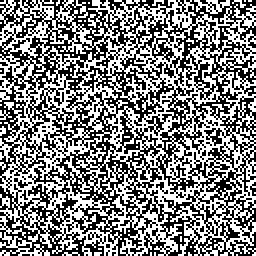

In [61]:
_ = process1(puzzle.input, visualize=True)

<a name="day15"></a>
## Day 15: Dueling generators

- Part 1: After 40 million pairs, what is the judge's final count?

- Part 2: After 5 million pairs, but using this new generator logic, what is the judge's final count?

In [62]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2017/day/15), `puzzle.input` has 2 lines:

Generator A starts with 618
Generator B starts with 814


The stored answers are: `{1: '577', 2: '316'}`

In [63]:
s1 = """
Generator A starts with 65
Generator B starts with 8921
"""

In [64]:
def process1(s, part2=False):
  state0, state1 = (int(line.split(' starts with ')[1]) for line in s.strip('\n').split('\n'))

  @numba_njit(cache=True)
  def compute(state0: int, state1: int) -> int:
    FACTOR0, FACTOR1 = 16807, 48271
    num_matches = 0
    num_checks = 5_000_000 if part2 else 40_000_000
    for index in range(num_checks):
      while True:
        state0 = (state0 * FACTOR0) % 2147483647
        if not part2 or state0 & 3 == 0:
          break
      while True:
        state1 = (state1 * FACTOR1) % 2147483647
        if not part2 or state1 & 7 == 0:
          break
      num_matches += (state0 & 65535) == (state1 & 65535)
    return num_matches

  return compute(state0, state1)


check_eq(process1(s1), 588)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 309)
puzzle.verify(2, process2)

(Part 1: 0.141 s)
(Part 2: 0.208 s)


<a name="day16"></a>
## Day 16: Permutation dance

- Part 1: In what order are the programs standing after their dance?

- Part 2: In what order are the programs standing after their billion dances?

In [65]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2017/day/16), `puzzle.input` has a single line of 48_576 characters:

x3/10,pl/g,s9,x6/15,s10,x9/1,pi/c,x4/10,s15,x13/7,s7,x11/6,s14,x5/7,pj/b,x15/9,s ... 3,x4/3,pc/n,x10/7,pa/b,s11,x13/4,s9


The stored answers are: `{1: 'olgejankfhbmpidc', 2: 'gfabehpdojkcimnl'}`

In [66]:
def process1(s, num=16):  # Simpler version supporting only Part 1.
  state = [chr(ord('a') + i) for i in range(num)]

  for move in s.strip('\n').split(','):
    operation, operands = move[0], move[1:]
    if operation == 's':
      size = int(operands)
      assert 1 <= size < num
      state = state[-size:] + state[:-size]
    elif operation == 'x':
      pos0, pos1 = (int(s2) for s2 in operands.split('/'))
      state[pos0], state[pos1] = state[pos1], state[pos0]
    elif operation == 'p':
      ch0, ch1 = operands.split('/')
      index0, index1 = state.index(ch0), state.index(ch1)
      state[index0], state[index1] = ch1, ch0
    else:
      raise AssertionError

  return ''.join(state)


check_eq(process1('s1,x3/4,pe/b', num=5), 'baedc')
puzzle.verify(1, process1)  # e.g. 'olgejankfhbmpidc'

(Part 1: 0.005 s)


In [67]:
def process1(s, num=16, num_permutations=1):
  # We track two permutations: a permutation on symbols, and a permutation on positions.
  perm_sym = list(range(num))  # Destination sym for each source sym.
  perm_pos = list(range(num))  # Destination pos for each source pos.

  for move in s.strip('\n').split(','):
    operation, operands = move[0], move[1:]
    if operation == 'p':
      sym0, sym1 = (ord(ch) - ord('a') for ch in operands.split('/'))
      index0, index1 = perm_sym.index(sym0), perm_sym.index(sym1)
      perm_sym[index0], perm_sym[index1] = sym1, sym0
    elif operation == 's':
      size = int(operands)
      assert 1 <= size < num
      for i, pos in enumerate(perm_pos):
        perm_pos[i] = pos + (size if pos < num - size else size - num)
    elif operation == 'x':
      pos0, pos1 = (int(s2) for s2 in operands.split('/'))
      index0, index1 = perm_pos.index(pos0), perm_pos.index(pos1)
      perm_pos[index0], perm_pos[index1] = pos1, pos0
    else:
      raise AssertionError

  def evaluate(perm_sym: list[int], perm_pos: list[int]) -> str:
    # Invert permutation using https://stackoverflow.com/a/11649931.
    return ''.join(chr(perm_sym[i] + ord('a')) for i in np.argsort(perm_pos))  # ??

  @functools.lru_cache(None)
  def compose(num_permutations: int) -> tuple(list(int), list(int)):
    if num_permutations == 1:
      return perm_sym, perm_pos
    num0, num1 = (num_permutations + 1) // 2, num_permutations // 2
    (perm_sym0, perm_pos0), (perm_sym1, perm_pos1) = compose(num0), compose(num1)
    return ([perm_sym1[sym0] for sym0 in perm_sym0],
            [perm_pos1[pos0] for pos0 in perm_pos0])

  return evaluate(*compose(num_permutations))


check_eq(process1('s1,x3/4,pe/b', num=5), 'baedc')
puzzle.verify(1, process1)  # e.g. 'olgejankfhbmpidc'

process2 = functools.partial(process1, num_permutations=1_000_000_000)
check_eq(process2('s1,x3/4,pe/b', num=5, num_permutations=2), 'ceadb')
puzzle.verify(2, process2)

(Part 1: 0.009 s)
(Part 2: 0.008 s)


<a name="day17"></a>
## Day 17: Circular buffer

- Part 1: What is the value after 2017 in your completed circular buffer?

- Part 2: What is the value after 0 the moment 50000000 is inserted?

In [68]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2017/day/17), `puzzle.input` has a single line of 3 characters:

349


The stored answers are: `{1: '640', 2: '47949463'}`

In [69]:
def process1(s, part2=False):
  step = int(s.strip('\n'))
  assert step > 0

  if not part2:
    pos = 0
    state = [0]

    for index in range(2017):
      pos = (pos + step) % len(state)
      state = state[:pos + 1] + [index + 1] + state[pos + 1:]
      pos = pos + 1

    return state[pos + 1]

  @numba_njit(cache=True)  # ~2.6 s -> ~0.16 s.
  def compute_part2():
    pos = 0
    after_zero = -1

    for index in range(1, 50_000_000 + 1):
      pos = (pos + step) % index + 1
      if pos == 1:
        after_zero = index

    return after_zero

  return compute_part2()


check_eq(process1('3'), 638)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

(Part 1: 0.006 s)
(Part 2: 0.158 s)


<a name="day18"></a>
## Day 18: Two async programs

- Part 1: What is the value of the recovered frequency (the value of the most recently played sound) the first time a rcv instruction is executed with a non-zero value?

- Part 2: Once both of your programs have terminated (regardless of what caused them to do so), how many times did program 1 send a value?

In [70]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2017/day/18), `puzzle.input` has 41 lines:

set i 31
set a 1
mul p 17
jgz p p
mul a 2
add i -1
jgz i -2
add a -1
 ...
jgz i -11
snd a
jgz f -16
jgz a -19


The stored answers are: `{1: '2951', 2: '7366'}`

In [71]:
s1 = """
set a 1
add a 2
mul a a
mod a 5
snd a
set a 0
rcv a
jgz a -1
set a 1
jgz a -2
"""

In [72]:
s2 = """
snd 1
snd 2
snd p
rcv a
rcv b
rcv c
rcv d
"""

In [73]:
def process1(s):
  instructions = [tuple(line.split(' ')) for line in s.strip('\n').split('\n')]
  pc = 0
  registers = collections.defaultdict(int)
  sound: int | None = None

  def get(value: str) -> int:
    return registers[value] if value.isalpha() else int(value)

  while True:
    assert 0 <= pc < len(instructions)
    operation, operand, *rest = instructions[pc]
    if operation == 'snd':
      assert not rest
      sound = get(operand)
    elif operation == 'rcv':
      assert not rest
      if get(operand) != 0:
        return sound
    elif operation == 'set':
      registers[operand] = get(*rest)
    elif operation == 'add':
      registers[operand] += get(*rest)
    elif operation == 'mul':
      registers[operand] *= get(*rest)
    elif operation == 'mod':
      registers[operand] %= get(*rest)
    elif operation == 'jgz':
      if get(operand) > 0:
        pc += get(*rest) - 1
    else:
      raise AssertionError
    pc += 1


check_eq(process1(s1), 4)
puzzle.verify(1, process1)

(Part 1: 0.001 s)


In [74]:
def process2(s):
  instructions = [tuple(line.split(' ')) for line in s.strip('\n').split('\n')]

  @dataclasses.dataclass
  class Program:
    program_id: int
    pc: int = 0
    registers: dict[str, int] = dataclasses.field(
        default_factory=lambda: collections.defaultdict(int))
    queue: collections.deque[int] = dataclasses.field(default_factory=lambda: collections.deque())
    total_sends: int = 0

    def __post_init__(self):
      self.registers['p'] = self.program_id

    def get(self, value: str) -> int:
      return self.registers[value] if value.isalpha() else int(value)

    def execute(self) -> bool:
      if not 0 <= self.pc < len(instructions):
        return False
      operation, operand, *rest = instructions[self.pc]
      if operation == 'snd':
        assert not rest
        other_program = programs[1 - self.program_id]
        other_program.queue.append(self.get(operand))
        self.total_sends += 1
      elif operation == 'rcv':
        assert not rest
        if not self.queue:
          return False
        self.registers[operand] = self.queue.popleft()
      elif operation == 'set':
        self.registers[operand] = self.get(*rest)
      elif operation == 'add':
        self.registers[operand] += self.get(*rest)
      elif operation == 'mul':
        self.registers[operand] *= self.get(*rest)
      elif operation == 'mod':
        self.registers[operand] %= self.get(*rest)
      elif operation == 'jgz':
        if self.get(operand) > 0:
          self.pc += self.get(*rest) - 1
      else:
        raise AssertionError
      self.pc += 1
      return True

  programs = [Program(0), Program(1)]
  while programs[0].execute() or programs[1].execute():
    pass
  return programs[1].total_sends


check_eq(process2(s2), 3)
puzzle.verify(2, process2)

(Part 2: 0.094 s)


<a name="day19"></a>
## Day 19: Follow 2D paths

- Part 1: What are the letters along the path?

- Part 2: How many steps does the packet need to go?

In [75]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2017/day/19), `puzzle.input` has 201 lines:

 |                                                                               ...                                    
 | +-----------------------------------------+         +------------------------ ... -------+ +-+           +---+       
 | |                                         |         |                         ...        | | |           |   |       
 | |                                         |   +------------------------------ ... -------+ | |           |   |       
 | |                                         |   |     |                         ...          | |           |   |       
 | |                                         |   |     |                         ... ---------|-|-----------+   |       
 | |                                         |   |     |                         ...          | |               |       
 | |                                         |   |     |                         ...  +-------|-|---------+     |       
 ...
 +--------Y----------------

The stored answers are: `{1: 'RYLONKEWB', 2: '16016'}`

In [76]:
s1 = """
     |          X
     |  +--+    X
     A  |  C    X
 F---|----E|--+ X
     |  |  |  D X
     +B-+  +--+ X
""".replace('X', '')

In [77]:
def process1(s, part2=False):
  grid = hh.grid_from_string(s)  # shape=(201, 201).
  grid = np.pad(grid, ((0, 1), (0, 1)), constant_values=' ')
  (y, x), = np.argwhere(grid[:1] == '|')
  dy, dx = 1, 0
  letters = []
  num_steps = 0

  while True:
    num_steps += 1
    y, x = y + dy, x + dx
    ch = grid[y, x]
    if ch.isalpha():
      letters.append(ch)
    elif ch == '+':
      dy, dx = dx, dy  # One of the two 90-degree rotations.
      if grid[y + dy, x + dx] == ' ':
        dy, dx = -dy, -dx  # The other possible 90-degree rotation.
      if grid[y + dy, x + dx] == ' ':
        raise AssertionError
    elif ch == ' ':
      return num_steps if part2 else ''.join(letters)
    else:
      assert ch in '|-', ch


check_eq(process1(s1), 'ABCDEF')
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 38)
puzzle.verify(2, process2)

(Part 1: 0.009 s)
(Part 2: 0.008 s)


<a name="day20"></a>
## Day 20: Accelerating 3D particles

- Part 1: Which particle will stay closest to position <0,0,0> in the long term?

- Part 2: How many particles are left after all collisions are resolved?

In [78]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2017/day/20), `puzzle.input` has 1_000 lines:

p=<-717,-4557,2578>, v=<153,21,30>, a=<-8,8,-7>
p=<1639,651,-987>, v=<29,-19,129>, a=<-5,0,-6>
p=<-10482,-248,-491>, v=<4,10,81>, a=<21,0,-4>
p=<-6607,-2542,1338>, v=<-9,52,-106>, a=<14,2,4>
p=<-4468,1178,-6474>, v=<146,44,66>, a=<0,-5,9>
p=<1298,-3391,-2843>, v=<-44,26,113>, a=<0,6,-1>
p=<-36,-1100,4900>, v=<62,22,56>, a=<-4,1,-15>
p=<-357,911,-1551>, v=<-1,16,141>, a=<2,-7,-6>
 ...
p=<1042,-1844,-1253>, v=<142,-261,-178>, a=<-14,17,10>
p=<-2337,2080,-901>, v=<-339,301,-128>, a=<18,-22,6>
p=<776,164,-2398>, v=<112,26,-342>, a=<-4,-3,23>
p=<60,851,-2490>, v=<8,120,-353>, a=<0,-14,24>


The stored answers are: `{1: '344', 2: '404'}`

In [79]:
s1 = """
p=< 3,0,0>, v=< 2,0,0>, a=<-1,0,0>
p=< 4,0,0>, v=< 0,0,0>, a=<-2,0,0>
"""

In [80]:
s2 = """
p=<-6,0,0>, v=< 3,0,0>, a=< 0,0,0>
p=<-4,0,0>, v=< 2,0,0>, a=< 0,0,0>
p=<-2,0,0>, v=< 1,0,0>, a=< 0,0,0>
p=< 3,0,0>, v=<-1,0,0>, a=< 0,0,0>
"""

In [81]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')

  def parse(ch: str) -> np.ndarray:
    prog = re.compile(ch + r'=<([0-9 -]+),([0-9 -]+),([0-9 -]+)>')
    return np.array([[int(t) for t in prog.search(line).groups()] for line in lines])

  position, velocity, acceleration = (parse(ch) for ch in 'pva')

  if not part2:
    time = 1_000_000
    position = position + velocity * time + acceleration * (time * (time + 1) // 2)
    return np.abs(position).sum(axis=1).argmin()

  for time in range(200):
    velocity += acceleration
    position += velocity
    unique, index, counts = np.unique(position, axis=0, return_index=True, return_counts=True)
    index = index[counts == 1]  # Indices of non-intersecting particles.
    position, velocity, acceleration = position[index], velocity[index], acceleration[index]

  return len(position)


check_eq(process1(s1), 0)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s2), 1)
puzzle.verify(2, process2)

(Part 1: 0.003 s)
(Part 2: 0.026 s)


<a name="day21"></a>
## Day 21: Super-resolution using rules

- Part 1: How many pixels stay on after 5 iterations?

- Part 2: How many pixels stay on after 18 iterations?

In [82]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2017/day/21), `puzzle.input` has 108 lines:

../.. => ###/.../#..
#./.. => #../.#./###
##/.. => #../###/#..
.#/#. => .#./##./#.#
##/#. => .#./.../...
##/## => .../#../#.#
.../.../... => #.##/#.../..##/.##.
#../.../... => .#../#..#/###./#.##
 ...
#.#/###/#.# => #..#/..../####/#.##
###/###/#.# => ####/..../.##./.#.#
###/#.#/### => .#.#/#..#/###./.##.
###/###/### => ##../#.##/.##./#..#


The stored answers are: `{1: '152', 2: '1956174'}`

In [83]:
s1 = """
../.# => ##./#../...
.#./..#/### => #..#/..../..../#..#
"""

In [84]:
def process1(s, num_iterations=5, visualize=False):

  def get_grid(s: str) -> np.ndarray:
    return (np.array([list(row) for row in s.split('/')]) == '#').astype(int)

  rules = {2: np.full((2**4, 3, 3), 0), 3: np.full((2**9, 4, 4), 0)}
  for line in s.strip('\n').split('\n'):
    grid_lhs, grid_rhs = map(get_grid, line.split(' => '))
    size = grid_lhs.shape[0]
    for _ in range(2):
      grid_lhs = np.fliplr(grid_lhs)
      for _ in range(4):
        grid_lhs = np.rot90(grid_lhs)
        encoded = grid_lhs.reshape(-1).dot(2**np.arange(size**2))
        rules[size][encoded] = grid_rhs

  grid = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]])

  grids = []
  for index in range(num_iterations):
    if visualize and index < 13:
      grids.append(grid == 0)
    n = grid.shape[0]
    size = 2 if n % 2 == 0 else 3
    new_size = {2: 3, 3: 4}[size]
    m = n // size
    new_n = m * new_size
    grid_blocks = grid.reshape(m, size, m, size).transpose(0, 2, 1, 3).reshape(m, m, size**2)
    encoded = grid_blocks.dot(2**np.arange(size**2))
    new_blocks = rules[size][encoded]
    grid = new_blocks.transpose(0, 2, 1, 3).reshape(new_n, new_n)

  if visualize:
    combined = hh.assemble_arrays(grids, (1, -1), background=True, spacing=8)
    combined = np.pad(combined, 4, constant_values=True)
    media.show_image(combined, border=True)

  return np.sum(grid)


check_eq(process1(s1, num_iterations=2), 12)
puzzle.verify(1, process1)

process2 = functools.partial(process1, num_iterations=18)  # grid.shape = (2187, 2187)
puzzle.verify(2, process2)

(Part 1: 0.010 s)
(Part 2: 0.084 s)


""

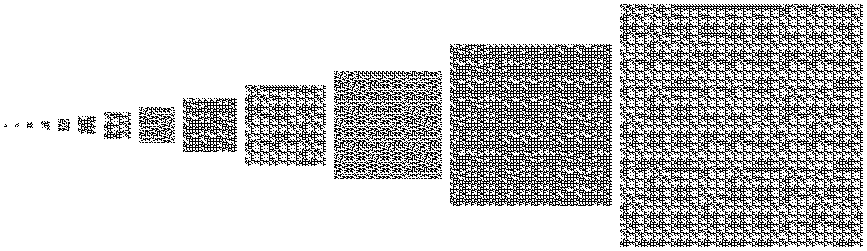

In [85]:
_ = process2(puzzle.input, visualize=True)

<a name="day22"></a>
## Day 22: Turtle graphics automaton

- Part 1: Given your actual map, after 10000 bursts of activity, how many bursts cause a node to become infected? (Do not count nodes that begin infected.)

- Part 2: With the addition of Weakened and Flagged, after 10000000 bursts of activity, how many bursts cause a node to become infected?

In [86]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2017/day/22), `puzzle.input` has 25 lines:

....##.#.#.#...#.##.##.#.
##.####..###..#.#.#.###.#
.#.#...#.##....#......###
...#.....##.###....##.###
#.########.#.#####..##.#.
.#..#..#.#..#....##.#...#
.....#.##..#.#.....##..##
....###....###....###.#..
 ...
#.#...#..##.###.....##.#.
#..#.##...##.##....#...#.
..#.#..#..#...##.#..###..
......###....#.....#....#


The stored answers are: `{1: '5570', 2: '2512022'}`

In [87]:
s1 = """
..#
#..
...
"""

In [88]:
def process1(s, num_iterations=10_000, part2=False, visualize=False):
  initial_grid = hh.grid_from_string(s)
  cy, cx = np.array(initial_grid.shape) // 2
  grid = {(y - cy, x - cx): '#' for y, x in np.argwhere(initial_grid == '#')}
  y, x = 0, 0
  dy, dx = -1, 0  # Up direction.
  num_newly_infected = 0
  UPDATE = {' ': 'W', 'W': '#', '#': 'F', 'F': ' '} if part2 else {' ': '#', '#': ' '}
  cmap = {' ': (235, 235, 235), '#': (255, 0, 0), 'W': (50, 50, 200), 'F': (0, 150, 0)}

  for index in range(num_iterations):
    state = grid.get((y, x), ' ')
    if state == ' ':
      dy, dx = -dx, dy  # Turn left.
    elif state == '#':
      dy, dx = dx, -dy  # Turn right.
    elif state == 'F':
      dy, dx = -dy, -dx  # Make U-turn.
    grid[y, x] = new_state = UPDATE[state]
    num_newly_infected += new_state == '#'
    y, x = y + dy, x + dx

  if visualize:
    # hh.show(max(abs(x) + abs(y) for y, x in grid))  # 335
    media.show_image(hh.image_from_yx_map(grid, background=' ', cmap=cmap))

  return num_newly_infected


check_eq(process1(s1, num_iterations=7), 5)
check_eq(process1(s1, num_iterations=70), 41)
check_eq(process1(s1), 5587)
puzzle.verify(1, process1)

process2 = functools.partial(process1, num_iterations=10_000_000, part2=True)
check_eq(process2(s1, num_iterations=100), 26)
# check_eq(process2(s1), 2_511_944)
# puzzle.verify(2, process2)  # ~2.2 s.

(Part 1: 0.002 s)


""

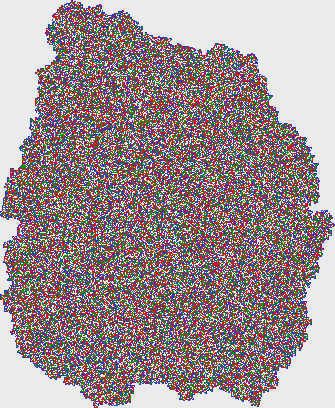

In [89]:
_ = process2(puzzle.input, visualize=True)

In [90]:
def process1(s, num_iterations=10_000, part2=False):
  grid = hh.grid_from_string(s,  {'.': 0, '#': 1})  # Later also: {'W': 2, 'F': 3}.
  pad = 500 if part2 else 200
  grid = np.pad(grid, pad)

  @numba_njit(cache=True)  # ~3.9 s -> ~0.05 s.
  def compute(grid):
    UPDATE = (2, 3, 1, 0) if part2 else (1, 0)
    y, x = grid.shape[0] // 2, grid.shape[1] // 2
    dy, dx = -1, 0  # Up direction.
    num_newly_infected = 0
    for index in range(num_iterations):
      state = grid[y, x]
      if state == 0:
        dy, dx = -dx, dy  # Turn left.
      elif state == 1:
        dy, dx = dx, -dy  # Turn right.
      elif state == 3:
        dy, dx = -dy, -dx  # Make U-turn.
      grid[y, x] = new_state = UPDATE[state]
      num_newly_infected += new_state == 1
      y, x = y + dy, x + dx
    return num_newly_infected

  return compute(grid)


check_eq(process1(s1, num_iterations=7), 5)
check_eq(process1(s1, num_iterations=70), 41)
check_eq(process1(s1), 5587)
puzzle.verify(1, process1)

process2 = functools.partial(process1, num_iterations=10_000_000, part2=True)
check_eq(process2(s1, num_iterations=100), 26)
check_eq(process2(s1), 2_511_944)
puzzle.verify(2, process2)

(Part 1: 0.002 s)
(Part 2: 0.055 s)


<a name="day23"></a>
## Day 23: Reverse-engineer program

- Part 1: If you run the program (your puzzle input), how many times is the mul instruction invoked?

- Part 2: After setting register a to 1, if the program were to run to completion, what value would be left in register h?

In [91]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2017/day/23), `puzzle.input` has 32 lines:

set b 93
set c b
jnz a 2
jnz 1 5
mul b 100
sub b -100000
set c b
sub c -17000
 ...
jnz g 2
jnz 1 3
sub b -17
jnz 1 -23


The stored answers are: `{1: '8281', 2: '911'}`

In [92]:
def process1(s, part2=False):
  instructions = [tuple(line.split(' ')) for line in s.strip('\n').split('\n')]
  pc = 0
  registers = collections.defaultdict(int)
  num_mul = 0
  registers['a'] = 1 if part2 else 0

  def get(value: str) -> int:
    return registers[value] if value.isalpha() else int(value)

  def is_prime(n: int) -> bool:
    return n > 1 and all(n % i != 0 for i in range(2, int(n**0.5) + 1))

  while 0 <= pc < len(instructions):
    # hh.show(pc, instructions[pc])
    if part2 and pc == 8:
      # Big optimization: directly compute the number of non-primes in range(b, c + 1, 17).
      result = sum(not is_prime(i) for i in range(get('b'), get('c') + 1, 17))
      return result
    operation, operand, operand2 = instructions[pc]
    if operation == 'set':
      registers[operand] = get(operand2)
    elif operation == 'sub':
      registers[operand] -= get(operand2)
    elif operation == 'mul':
      registers[operand] *= get(operand2)
      num_mul += 1
    elif operation == 'jnz':
      if get(operand) != 0:
        pc += get(operand2) - 1
    else:
      raise AssertionError
    pc += 1

  return num_mul


puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

(Part 1: 0.015 s)
(Part 2: 0.002 s)


In [93]:
# print('\n'.join(f'# L{i:02} {line:14} # ' for i, line in enumerate(puzzle.input.split('\n'))))

# L00 set b 93       # b = 93
# L01 set c b        # c = b
# L02 jnz a 2        # if a != 0: jmp L04
# L03 jnz 1 5        # jmp L08

# L04 mul b 100      # b *= 100
# L05 sub b -100000  # b += 100_000
# L06 set c b        # c = b
# L07 sub c -17000   # c += 17_000

# L08 set f 1        # f = 1
# L09 set d 2        # d = 2

# L10 set e 2        # e = 2

# L11 set g d        # g = d
# L12 mul g e        # g *= e
# L13 sub g b        # g -= b
# L14 jnz g 2        # if g != 0: goto L16
# L15 set f 0        # f = 0

# L16 sub e -1       # e += 1
# L17 set g e        # g = e
# L18 sub g b        # g -= b
# L19 jnz g -8       # if g != 0: goto L11
# L20 sub d -1       # d += 1
# L21 set g d        # g = d
# L22 sub g b        # g -= b
# L23 jnz g -13      # if g != 0: goto L10
# L24 jnz f 2        # if f != 0: goto L26
# L25 sub h -1       # h += 1

# L26 set g b        # g = b
# L27 sub g c        # g -= c
# L28 jnz g 2        # if g != 0: goto L30
# L29 jnz 1 3        # exit

# L30 sub b -17      # b += 17
# L31 jnz 1 -23      # goto L08

In [94]:
# L00 set b 93       #
# L01 set c b        #
# L04 mul b 100      #
# L05 sub b -100000  # b = 109_300
# L06 set c b        #
# L07 sub c -17000   # c = 126_300

# With a=0: b=93 c=93 num=1
# With a=1: b=109_300 c=126_301 num=1000

#                    # for b in range(b, c + 1, 17):
# L08 set f 1        #   f = 1
# L09 set d 2        #   d = 2

# L10 set e 2        #   for e in range(2, b + 1):
# L11 set g d        #
# L12 mul g e        #
# L13 sub g b        #
# L14 jnz g 2        #     if d * e == b: f = 0   # if b % d == 0: f = 0
# L15 set f 0        #
# L16 sub e -1       #
# L17 set g e        #
# L18 sub g b        #
# L19 jnz g -8       #
# L20 sub d -1       #   d += 1
# L21 set g d        #
# L22 sub g b        #
# L23 jnz g -13      #   if d != b: goto L10
# L24 jnz f 2        #   if f == 0:
# L25 sub h -1       #     h += 1
# L26 set g b        #
# L27 sub g c        #
# L28 jnz g 2        #
# L30 sub b -17      #
# L31 jnz 1 -23      #

In [95]:
# for b in range(b, c + 1, 17):
#   f = 1
#
#   for d in range(2, b + 1):
#     if b % d == 0: f = 0
#
#   if f == 0:
#     h += 1

<a name="day24"></a>
## Day 24: Long domino chains

- Part 1: What is the strength of the strongest bridge you can make with the components you have available?

- Part 2: Of all bridges of the longest possible length, what is the strength of the strongest one?

In [96]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2017/day/24), `puzzle.input` has 57 lines:

14/42
2/3
6/44
4/10
23/49
35/39
46/46
5/29
 ...
48/10
28/28
2/13
48/14


The stored answers are: `{1: '1695', 2: '1673'}`

In [97]:
s1 = """
0/2
2/2
2/3
3/4
3/5
0/1
10/1
9/10
"""

In [98]:
def process1(s, start=0, part2=False):  # Slower, creating list of updated remaining components.
  components = [tuple(map(int, line.split('/'))) for line in s.strip('\n').split('\n')]
  check_eq(len(components), len(set(components)))  # In fact, they are all unique.

  def compatible_components(start: int, components: list[tuple[int, int]]):
    for i, (v0, v1) in enumerate(components):
      if v1 == start:
        v1 = v0
      elif v0 != start:
        continue
      remaining = components[:i] + components[i + 1:]
      yield v1, remaining

  def compute_strongest(v0: int, components: list[tuple[int, int]]) -> int:
    max_strength = 0
    for v1, remaining in compatible_components(v0, components):
      max_strength = max(max_strength, v0 + v1 + compute_strongest(v1, remaining))
    return max_strength

  if not part2:
    return compute_strongest(start, components)

  def compute_longest_length(v0: int, components: list[tuple[int, int]]) -> int:
    max_length = 0
    for v1, remaining in compatible_components(v0, components):
      max_length = max(max_length, 1 + compute_longest_length(v1, remaining))
    return max_length

  def compute_longest(v0: int, remaining_length: int, components: list[tuple[int, int]]) -> int:
    max_strength = 0 if remaining_length == 0 else -10_000
    for v1, remaining in compatible_components(v0, components):
      max_strength = max(
          max_strength, v0 + v1 + compute_longest(v1, remaining_length - 1, remaining))
    return max_strength

  longest_length = compute_longest_length(start, components)
  return compute_longest(start, longest_length, components)


check_eq(process1(s1), 31)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 19)
puzzle.verify(2, process2)

(Part 1: 0.799 s)
(Part 2: 1.615 s)


In [99]:
def process1(s, start=0, part2=False):  # Faster, with side effects on sets of remaining components.
  components = [tuple(map(int, line.split('/'))) for line in s.strip('\n').split('\n')]
  max_v = max(max(v0, v1) for v0, v1 in components)
  active_from_v = [set() for v in range(max_v + 1)]
  for v0, v1 in components:
    active_from_v[v0].add(v1)
    if v1 != v0:
      active_from_v[v1].add(v0)

  def compatible_components(v0: int) -> Iterator[int]:
    set_v0 = active_from_v[v0]
    for v1 in list(set_v0):
      if v1 != v0:
        set_v1 = active_from_v[v1]
        set_v0.remove(v1), set_v1.remove(v0)
        yield v1
        set_v1.add(v0), set_v0.add(v1)
      else:
        set_v0.remove(v1)
        yield v1
        set_v0.add(v1)

  def compute_strongest(v0: int) -> int:
    max_strength = 0
    for v1 in compatible_components(v0):
      max_strength = max(max_strength, v0 + v1 + compute_strongest(v1))
    return max_strength

  if not part2:
    return compute_strongest(start)

  def compute_longest_length(v0: int) -> int:
    max_length = 0
    for v1 in compatible_components(v0):
      max_length = max(max_length, 1 + compute_longest_length(v1))
    return max_length

  def compute_longest(v0: int, remaining_length: int) -> int:
    max_strength = 0 if remaining_length == 0 else -10_000
    for v1 in compatible_components(v0):
      max_strength = max(max_strength, v0 + v1 + compute_longest(v1, remaining_length - 1))
    return max_strength

  longest_length = compute_longest_length(start)  # 36
  return compute_longest(start, longest_length)


check_eq(process1(s1), 31)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 19)
puzzle.verify(2, process2)

(Part 1: 0.241 s)
(Part 2: 0.476 s)


<a name="day25"></a>
## Day 25: Turing machine

- Part 1: After the specified number of steps have been executed, count the number of times 1 appears on the tape.

- Part 2: None on day 25.

In [100]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2017/day/25), `puzzle.input` has 62 lines:

Begin in state A.
Perform a diagnostic checksum after 12208951 steps.

In state A:
  If the current value is 0:
    - Write the value 1.
    - Move one slot to the right.
    - Continue with state B.
 ...
  If the current value is 1:
    - Write the value 1.
    - Move one slot to the right.
    - Continue with state A.


The stored answers are: `{1: '4387', 2: ''}`

In [101]:
s1 = """
Begin in state A.
Perform a diagnostic checksum after 6 steps.

In state A:
  If the current value is 0:
    - Write the value 1.
    - Move one slot to the right.
    - Continue with state B.
  If the current value is 1:
    - Write the value 0.
    - Move one slot to the left.
    - Continue with state B.

In state B:
  If the current value is 0:
    - Write the value 1.
    - Move one slot to the left.
    - Continue with state A.
  If the current value is 1:
    - Write the value 1.
    - Move one slot to the right.
    - Continue with state A.
"""

In [102]:
def process1(s):  # Slow version using dicts and Python.
  parts = s.strip('\n').split('\n\n')
  state, s_steps = re.match(r'(?s)Begin in state (.+)\..* after (.+) steps', parts[0]).groups()
  num_steps = int(s_steps)
  logic = {}
  for part in parts[1:]:
    current, = re.match(r'In state (.+):', part).groups()
    conditions = part.split('If the current ')[1:]
    assert len(conditions) == 2
    for condition in conditions:
      pattern = r'(?s)value is (.+):.*Write the value (.+)\..*to the (.+)\..* state (.+)\.'
      condition_state, s_write_value, s_move, next_state = re.match(pattern, condition).groups()
      logic[current, int(condition_state)] = (
          int(s_write_value), {'left': -1, 'right': +1}[s_move], next_state)

  tape = collections.defaultdict(int)
  pos = 0
  for index in range(num_steps):
    write_value, move, state = logic[state, tape[pos]]
    tape[pos] = write_value
    pos += move

  # hh.Stats(record_pos) = ( 12_208_951)        -6960 : 28           av=-3000.24     sd=3422.89
  return sum(tape.values())


check_eq(process1(s1), 3)
puzzle.verify(1, process1)  # ~1.1 s.

(Part 1: 1.188 s)


In [103]:
def process1(s, size=100_000):  # Fast version using integer arrays and jitted numba.
  parts = s.strip('\n').split('\n\n')
  s_state, s_steps = re.match(r'(?s)Begin in state (.+)\..* after (.+) steps', parts[0]).groups()
  state, num_steps = ord(s_state) - ord('A'), int(s_steps)

  logic_lines: list[tuple[int, int, int]] = []  # (write_value, move, next_state)
  for part in parts[1:]:
    for condition in part.split('If the current ')[1:]:
      pattern = r'(?s)Write the value (.+)\..*to the (.+)\..* state (.+)\.'
      s_write_value, s_move, s_next_state = re.search(pattern, condition).groups()
      logic_lines.append(
          (int(s_write_value), {'left': -1, 'right': +1}[s_move], ord(s_next_state) - ord('A')))
  logic = np.array(logic_lines)

  @numba_njit(cache=True)  # ~10.5 s -> 0.05 s.
  def compute(state):
    tape = np.full(size, 0)
    pos = size // 2
    for index in range(num_steps):
      write_value, move, state = logic[state * 2 + tape[pos]]
      tape[pos] = write_value
      pos += move
    return np.sum(tape)

  return compute(state)


check_eq(process1(s1), 3)
puzzle.verify(1, process1)

(Part 1: 0.051 s)


You deposit all fifty stars and reboot the printer. Suddenly, everything seems a lot less pixelated than before."--raise your priority level enough to send the reboot command and... hey look, it's printing! I'll bring it to Santa. Thanks!" She runs off.
Congratulations!  You've finished every puzzle in Advent of Code 2017!  I hope you had as much fun solving them as I had making them for you.  I'd love to hear about your adventure; you can get in touch with me via contact info on my website or through Twitter.
If you'd like to see more things like this in the future, please consider supporting Advent of Code and sharing it with others.
To hear about future projects, you can follow me on Twitter.
I've highlighted the easter eggs in each puzzle, just in case you missed any.  Hover your mouse over them, and the easter egg will appear.

In [104]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)
# (aocd does not allow a blank answer; the answer is not submitted)

(Part 2: 0.000 s)


<a name="timings"></a>
## Timings

In [105]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.000
day_2    part_1: 0.000   part_2: 0.000
day_3    part_1: 0.000   part_2: 0.000
day_4    part_1: 0.000   part_2: 0.001
day_5    part_1: 0.002   part_2: 0.030
day_6    part_1: 0.012   part_2: 0.011
day_7    part_1: 0.064   part_2: 0.010
day_8    part_1: 0.001   part_2: 0.001
day_9    part_1: 0.002   part_2: 0.001
day_10   part_1: 0.000   part_2: 0.007
day_11   part_1: 0.002   part_2: 0.002
day_12   part_1: 0.005   part_2: 0.003
day_13   part_1: 0.001   part_2: 0.005
day_14   part_1: 0.256   part_2: 0.281
day_15   part_1: 0.141   part_2: 0.208
day_16   part_1: 0.009   part_2: 0.008
day_17   part_1: 0.006   part_2: 0.158
day_18   part_1: 0.001   part_2: 0.094
day_19   part_1: 0.009   part_2: 0.008
day_20   part_1: 0.003   part_2: 0.026
day_21   part_1: 0.010   part_2: 0.084
day_22   part_1: 0.002   part_2: 0.055
day_23   part_1: 0.015   part_2: 0.002
day_24   part_1: 0.241   part_2: 0.476
day_25   part_1: 0.051   part_2: 0.000
Total time:  2.306 s


In [106]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [107]:
if 1:  # Look for unwanted pollution of namespace.
  print(textwrap.fill(' '.join(var for var, value in globals().items() if not (
      var.startswith('_') or var in _ORIGINAL_GLOBALS))))

puzzle process1 process2 s1 s2 spiral_yx


In [108]:
if 0:  # Save puzzle inputs and answers to a compressed archive for downloading.
  # Create a new tar.gz file.
  hh.run(f"""cd /mnt/c/hh/tmp && cp -rp ~/.config/aocd/'{PROFILE.replace("_", " ")}' '{PROFILE}' && tar -czf '{PROFILE}.tar.gz' '{PROFILE}'""")

In [109]:
hh.show_notebook_cell_top_times()

# Total time: 11.90 s
# In[ 98] def process1(s, start=0, part2=False):  # Slower, creating   2.425 s
# In[ 89] _ = process2(puzzle.input, visualize=True)                   2.365 s
# In[102] def process1(s):  # Slow version using dicts and Python.\n   1.203 s
# In[ 60] def process1(s, part2=False, visualize=False):\n  s = s.     1.070 s
# In[ 64] def process1(s, part2=False):\n  state0, state1 = (int(      0.719 s
# In[ 99] def process1(s, start=0, part2=False):  # Faster, with       0.719 s
# In[ 56] def process2(s, chunk=3_000):  # Use numpy vectorized over   0.560 s
# In[ 57] def process2(s, chunk=80_000):  # Use numpy sieve,           0.404 s
# In[ 61] _ = process1(puzzle.input, visualize=True)                   0.271 s
# In[ 31] def process1(s, part2=False):  # Fast.\n  values = np.       0.179 s
# In[ 69] def process1(s, part2=False):\n  step = int(s.strip('\\n'))  0.177 s
# In[ 90] def process1(s, num_iterations=10_000, part2=False):\n       0.125 s
# In[  9] try:\n  import numba

# End

In [110]:
def process1(s, part2=False):
  grid = np.array([[int(c) for c in line] for line in s.strip().split('\n')])
  for line in s.strip('\n').split('\n'):
    pass

  return None

# check_eq(process1(s1), 17)
# puzzle.verify(1, process1)

# process2 = functools.partial(process1, part2=True)
# check_eq(process1(s1), 18)
# puzzle.verify(2, process2)

[[Open the notebook in mybinder.org]](https://mybinder.org/v2/gh/hhoppe/advent_of_code_2017/main?filepath=advent_of_code_2017.ipynb)

Currently there are problems in using `numba` within `mybinder.org`
(i.e., after `pip install numba`):
- `numpy` requires older `numba==0.51.2`
- `njit(cache=True)` fails at runtime, for unknown reason.

<!-- For Emacs:
Local Variables:
fill-column: 80
End:
-->